In [ ]:
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.models import load_model
import re

In [ ]:
df = pd.read_csv('Emotion_final.csv')

In [ ]:
df.head()

,Text,Emotion
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


In [ ]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'#\w+', '', text)
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'\W', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

df['cleaned_text'] = df['Text'].apply(clean_text)

In [ ]:
df.tail()

,Text,Emotion,cleaned_text
21454,Melissa stared at her friend in dism,fear,melissa stared at her friend in dism
21455,Successive state elections have seen the gover...,fear,successive state elections have seen the gover...
21456,Vincent was irritated but not dismay,fear,vincent was irritated but not dismay
21457,Kendall-Hume turned back to face the dismayed ...,fear,kendall hume turned back to face the dismayed ...
21458,"I am dismayed , but not surpris",fear,i am dismayed but not surpris


In [ ]:
print('panjang Data : ', len(df))

panjang Data :  21459


In [ ]:
df['Emotion'].value_counts()

happy       7029
sadness     6265
anger       2993
fear        2652
love        1641
surprise     879
Name: Emotion, dtype: int64

In [ ]:
# Cek duplikasi dan hitung jumlah baris yang duplikat
duplicated_rows_count = df.duplicated().sum()

# Tampilkan jumlah baris yang duplikat
print(f"Jumlah Baris Duplikat: {duplicated_rows_count}")

# Cek duplikasi berdasarkan kolom tertentu dan hitung jumlah baris yang duplikat
duplicated_rows_by_column_count = df.duplicated(subset=['Text']).sum()

# Tampilkan jumlah baris yang duplikat berdasarkan kolom
print(f"Jumlah Baris Duplikat Berdasarkan Kolom: {duplicated_rows_by_column_count}")


Jumlah Baris Duplikat: 3
Jumlah Baris Duplikat Berdasarkan Kolom: 54


In [ ]:
# Cek apakah ada nilai yang kosong di seluruh DataFrame
missing_values = df.isnull().sum()

# Cek apakah ada nilai yang kosong di kolom tertentu (ganti 'column_name' dengan nama kolom yang ingin diperiksa)
missing_values_by_column = df['Text'].isnull().sum()

# Tampilkan jumlah nilai yang kosong
print("Jumlah Nilai Kosong Keseluruhan:")
print(missing_values)

print("\nJumlah Nilai Kosong Berdasarkan Kolom:")
print(missing_values_by_column)


Jumlah Nilai Kosong Keseluruhan:
Text            0
Emotion         0
cleaned_text    0
dtype: int64

Jumlah Nilai Kosong Berdasarkan Kolom:
0


In [ ]:
# Hapus baris yang duplikat secara langsung pada DataFrame asli
df.drop_duplicates(inplace=True)

In [ ]:
max_words = 10000
tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(df['cleaned_text'])

sequences = tokenizer.texts_to_sequences(df['cleaned_text'])
padded_sequences = pad_sequences(sequences)

label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(df['Emotion'])
one_hot_labels = to_categorical(encoded_labels, num_classes=len(set(df['Emotion'])))


In [ ]:
label_mapping = pd.DataFrame({'Label': encoded_labels, 'label': df['Emotion']}).drop_duplicates().reset_index(drop=True)
print(label_mapping)

   Label     label
0      4   sadness
1      0     anger
2      3      love
3      5  surprise
4      1      fear
5      2     happy


In [ ]:
X_train, X_temp, y_train, y_temp = train_test_split(padded_sequences, one_hot_labels, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)


In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint(filepath='best_model.h5', monitor='val_accuracy', save_best_only=True)


In [ ]:
num_classes = len(set(df['Emotion']))
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=max_words, output_dim=16, input_length=padded_sequences.shape[1]),
    tf.keras.layers.LSTM(64, return_sequences=False),
    tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])


In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
num_epochs = 50

history = model.fit(X_train, y_train, epochs=num_epochs, validation_data=(X_val, y_val), callbacks=[early_stopping, model_checkpoint], verbose=2)



Epoch 1/50
403/403 - 20s - loss: 1.8655 - accuracy: 0.3247 - val_loss: 1.5428 - val_accuracy: 0.3221 - 20s/epoch - 51ms/step
Epoch 2/50


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


403/403 - 17s - loss: 1.2855 - accuracy: 0.3974 - val_loss: 1.2035 - val_accuracy: 0.4258 - 17s/epoch - 43ms/step
Epoch 3/50
403/403 - 17s - loss: 1.0758 - accuracy: 0.4439 - val_loss: 1.1316 - val_accuracy: 0.4304 - 17s/epoch - 42ms/step
Epoch 4/50
403/403 - 17s - loss: 0.9857 - accuracy: 0.4907 - val_loss: 1.1212 - val_accuracy: 0.4584 - 17s/epoch - 42ms/step
Epoch 5/50
403/403 - 17s - loss: 0.9001 - accuracy: 0.5745 - val_loss: 1.0059 - val_accuracy: 0.6220 - 17s/epoch - 43ms/step
Epoch 6/50
403/403 - 17s - loss: 0.7355 - accuracy: 0.7124 - val_loss: 0.9730 - val_accuracy: 0.6786 - 17s/epoch - 42ms/step
Epoch 7/50
403/403 - 17s - loss: 0.6269 - accuracy: 0.7513 - val_loss: 0.8911 - val_accuracy: 0.6791 - 17s/epoch - 42ms/step
Epoch 8/50
403/403 - 17s - loss: 0.5640 - accuracy: 0.7698 - val_loss: 0.8454 - val_accuracy: 0.7073 - 17s/epoch - 42ms/step
Epoch 9/50
403/403 - 17s - loss: 0.5157 - accuracy: 0.7882 - val_loss: 0.8292 - val_accuracy: 0.7099 - 17s/epoch - 42ms/step
Epoch 10/50

In [ ]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Akurasi: {accuracy*100:.2f}%›')

135/135 [==============================] - 2s 11ms/step - loss: 0.5487 - accuracy: 0.8879
Akurasi: 88.79%›


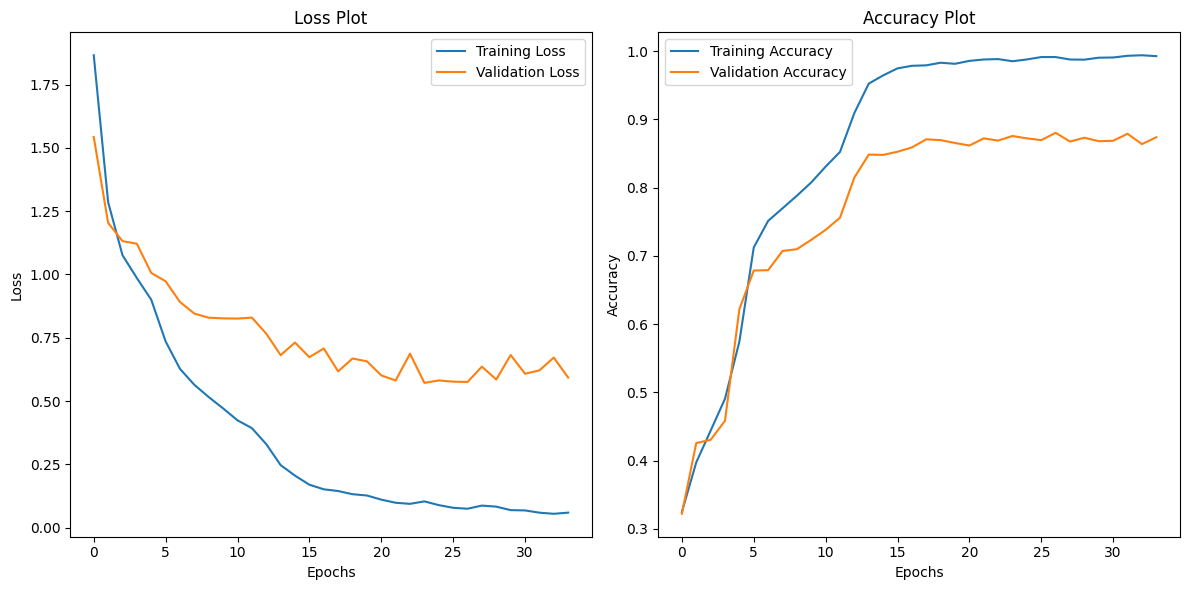

In [ ]:

# Plot loss dan akurasi
plt.figure(figsize=(12, 6))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Plot')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot Akurasi
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Plot')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
import numpy as np

# Fungsi untuk melakukan tokenisasi dan padding pada teks baru
def preprocess_text(text):
    text = text.lower()
    sequence = tokenizer.texts_to_sequences([text])
    padded_sequence = pad_sequences(sequence, maxlen=padded_sequences.shape[1])
    return padded_sequence

# Contoh teks baru untuk diuji
new_text = str(input("masukan teks : "))

# Preprocess teks baru
preprocessed_text = preprocess_text(new_text)

# Lakukan prediksi dengan model
prediction = model.predict(preprocessed_text)

# Decode prediksi menjadi label
predicted_label = label_encoder.classes_[np.argmax(prediction)]

# Tampilkan hasil
print(f'Teks: {new_text}')
print(f'Prediksi: {predicted_label}')


masukan teks : Frustration boiling over today. 🤬 Some days, it feels like everything's testing patience. Taking a deep breath, but the storm inside is real. 
1/1 [==============================] - 0s 28ms/step
Teks: Frustration boiling over today. 🤬 Some days, it feels like everything's testing patience. Taking a deep breath, but the storm inside is real. 
Prediksi: sadness
